# **Description**

LSTW is a large-scale, country-wide dataset for transportation and traffic research, which contains traffic and weather event data for the United States. In terms of traffic, we have several types of events including accident, congestion, construction, etc. In terms of weather events, we have several types including rain, snow, storm, cold weather event, etc. This dataset is continuously being collected from August 2016, and today it contains about 37 million traffic and weather events. Please read below descriptions for further details on this dataset

## **Columns Description:**

**Severity** : 	The severity is a value between 0 and 4, where 0 indicates the least impact on traffic (i.e., short delay as a result of the event) and 4 indicates a significant impact on traffic (i.e., long delay)

**Types of Weather Type**

**Severe-Cold:** The case of having extremely low temperature, with temperature below -23.7 degrees of Celsius.

**Fog:** The case where there is low visibility condition as a result of fog or haze.

**Hail:** The case of having solid precipitation including ice pellets and hail.

**Rain:** The case of having rain, ranging from light to heavy.

**Snow:** The case of having snow, ranging from light to heavy.

**Storm:** The extremely windy condition, where the wind speed is at least 60 km/h.

**Other Precipitation:** Any other type of precipitation which cannot be assigned to previously described event types.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.4 MB/s eta 0:00:00


In [ ]:
pip install lightgbm

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cat
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
import folium
from folium.plugins import HeatMap

Importing Data and merging it into one for further analysis

In [ ]:
data_2016 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_2016.csv')

In [ ]:
data_2017 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_2017.csv')

In [ ]:
data_2018 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_2018.csv')

In [ ]:
data_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_2019.csv')

In [ ]:
data_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_2020.csv')

In [ ]:
# Create a list of DataFrames
df_list = [data_2016, data_2017, data_2018, data_2019, data_2020]

# Concatenate the DataFrames
merged_data = pd.concat(df_list)


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Severity_x        380746 non-null  int64  
 1   StartTime(UTC)_x  380746 non-null  object 
 2   EndTime(UTC)_x    380746 non-null  object 
 3   TimeZone          380746 non-null  object 
 4   LocationLat_x     380746 non-null  float64
 5   LocationLng_x     380746 non-null  float64
 6   AirportCode       380746 non-null  object 
 7   City              380746 non-null  object 
 8   State             380746 non-null  object 
 9   ZipCode           380746 non-null  int64  
 10  ID                380746 non-null  int64  
 11  Weekday           380746 non-null  object 
 12  month             380746 non-null  int64  
 13  year              380746 non-null  int64  
 14  date_time_x       380746 non-null  object 
 15  date              380746 non-null  object 
 16  Type              380

In [ ]:
merged_data.head()

,Severity_x,StartTime(UTC)_x,EndTime(UTC)_x,TimeZone,LocationLat_x,LocationLng_x,AirportCode,City,State,ZipCode,...,year,date_time_x,date,Type,Severity_y,StartTime(UTC)_y,EndTime(UTC)_y,LocationLat_y,LocationLng_y,date_time_y
0,2,2016-12-01 03:38:32,2016-12-01 04:08:21,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,...,2016,2016-12-01 03:38:32,2016-12-01,Fog,Severe,2016-12-01 11:27:00,2016-12-01 11:34:00,39.1278,-123.2001,2016-12-01 11:27:00
1,2,2016-12-01 03:57:44,2016-12-01 04:27:26,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,...,2016,2016-12-01 03:57:44,2016-12-01,Fog,Moderate,2016-12-01 14:45:00,2016-12-01 15:45:00,37.3805,-120.5682,2016-12-01 14:45:00
2,2,2016-12-01 05:13:53,2016-12-01 05:43:53,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,...,2016,2016-12-01 05:13:53,2016-12-01,Cold,Severe,2016-12-01 21:47:00,2016-12-01 22:47:00,37.5119,-122.2483,2016-12-01 21:47:00
3,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,...,2016,2016-12-01 19:34:31,2016-12-01,Fog,Severe,2016-12-01 12:17:00,2016-12-01 12:56:00,38.2132,-122.2807,2016-12-01 12:17:00
4,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,...,2016,2016-12-01 19:34:31,2016-12-01,Fog,Severe,2016-12-01 13:32:00,2016-12-01 14:29:00,38.2132,-122.2807,2016-12-01 13:32:00


Removing additional duplicate columns after merge

In [ ]:
cols_to_drop = ['date_time_x', 'date_time_y','LocationLat_y','LocationLng_y','StartTime(UTC)_y','EndTime(UTC)_y','ID']
merged_data = merged_data.drop(cols_to_drop, axis=1)

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Severity_x        380746 non-null  int64  
 1   StartTime(UTC)_x  380746 non-null  object 
 2   EndTime(UTC)_x    380746 non-null  object 
 3   TimeZone          380746 non-null  object 
 4   LocationLat_x     380746 non-null  float64
 5   LocationLng_x     380746 non-null  float64
 6   AirportCode       380746 non-null  object 
 7   City              380746 non-null  object 
 8   State             380746 non-null  object 
 9   ZipCode           380746 non-null  int64  
 10  Weekday           380746 non-null  object 
 11  month             380746 non-null  int64  
 12  year              380746 non-null  int64  
 13  date              380746 non-null  object 
 14  Type              380746 non-null  object 
 15  Severity_y        380746 non-null  object 
dtypes: float64(2), int64(

In [ ]:
merged_data.head()

,Severity_x,StartTime(UTC)_x,EndTime(UTC)_x,TimeZone,LocationLat_x,LocationLng_x,AirportCode,City,State,ZipCode,Weekday,month,year,date,Type,Severity_y
0,2,2016-12-01 03:38:32,2016-12-01 04:08:21,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,2016-12-01,Fog,Severe
1,2,2016-12-01 03:57:44,2016-12-01 04:27:26,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,2016-12-01,Fog,Moderate
2,2,2016-12-01 05:13:53,2016-12-01 05:43:53,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,2016-12-01,Cold,Severe
3,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe
4,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe


Rename columns to make them more relevant

In [ ]:
merged_data.rename(columns={'Severity_x': 'Severity'}, inplace=True)
merged_data.rename(columns={'StartTime(UTC)_x': 'StartTime(UTC)'}, inplace=True)
merged_data.rename(columns={'EndTime(UTC)_x': 'EndTime(UTC)'}, inplace=True)
merged_data.rename(columns={'LocationLat_x': 'LocationLat'}, inplace=True)
merged_data.rename(columns={'LocationLng_x': 'LocationLng'}, inplace=True)
merged_data.rename(columns={'Severity_y': 'Weather_Severity'}, inplace=True)
merged_data.rename(columns={'Type': 'Weather_Type'}, inplace=True)

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Severity          380746 non-null  int64  
 1   StartTime(UTC)    380746 non-null  object 
 2   EndTime(UTC)      380746 non-null  object 
 3   TimeZone          380746 non-null  object 
 4   LocationLat       380746 non-null  float64
 5   LocationLng       380746 non-null  float64
 6   AirportCode       380746 non-null  object 
 7   City              380746 non-null  object 
 8   State             380746 non-null  object 
 9   ZipCode           380746 non-null  int64  
 10  Weekday           380746 non-null  object 
 11  month             380746 non-null  int64  
 12  year              380746 non-null  int64  
 13  date              380746 non-null  object 
 14  Weather_Type      380746 non-null  object 
 15  Weather_Severity  380746 non-null  object 
dtypes: float64(2), int64(

In [ ]:
merged_data.head()

,Severity,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,AirportCode,City,State,ZipCode,Weekday,month,year,date,Weather_Type,Weather_Severity
0,2,2016-12-01 03:38:32,2016-12-01 04:08:21,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,2016-12-01,Fog,Severe
1,2,2016-12-01 03:57:44,2016-12-01 04:27:26,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,2016-12-01,Fog,Moderate
2,2,2016-12-01 05:13:53,2016-12-01 05:43:53,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,2016-12-01,Cold,Severe
3,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe
4,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe


**Data Preparation**

In [ ]:
merged_data['day'] = pd.to_datetime(merged_data['StartTime(UTC)']).dt.day

In [ ]:
merged_data['StartTime(UTC)'] = pd.to_datetime(merged_data['StartTime(UTC)'])

In [ ]:
merged_data['hour'] = merged_data['StartTime(UTC)'].dt.hour
merged_data['minute'] = merged_data['StartTime(UTC)'].dt.minute
merged_data['second'] = merged_data['StartTime(UTC)'].dt.second

In [ ]:
merged_data.head()

,Severity,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,AirportCode,City,State,ZipCode,Weekday,month,year,date,Weather_Type,Weather_Severity,day,hour,minute,second
0,2,2016-12-01 03:38:32,2016-12-01 04:08:21,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,2016-12-01,Fog,Severe,1,3,38,32
1,2,2016-12-01 03:57:44,2016-12-01 04:27:26,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,2016-12-01,Fog,Moderate,1,3,57,44
2,2,2016-12-01 05:13:53,2016-12-01 05:43:53,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,2016-12-01,Cold,Severe,1,5,13,53
3,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe,1,19,34,31
4,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe,1,19,34,31


Univariate Analysis

<Axes: >

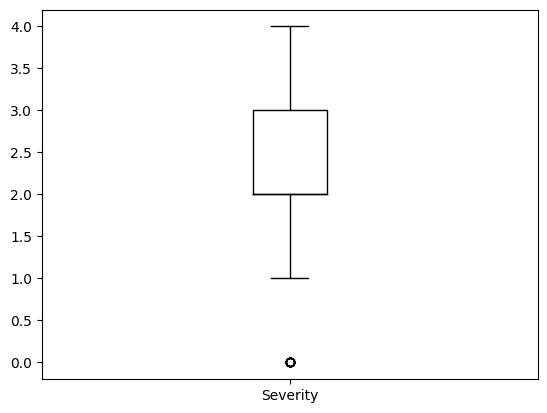

In [ ]:
import matplotlib.pyplot as plt

merged_data.boxplot(column=['Severity'], grid=False, color='black')

<Axes: >

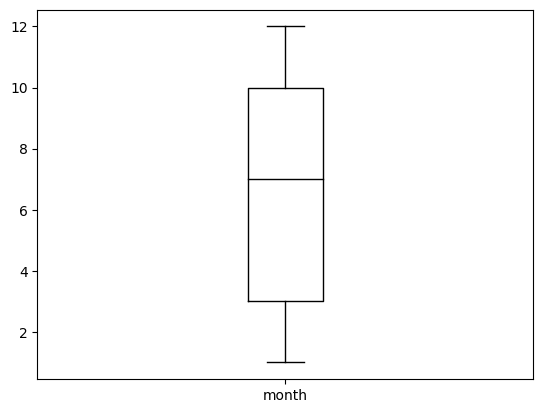

In [ ]:
merged_data.boxplot(column=['month'], grid=False, color='black')

<Axes: >

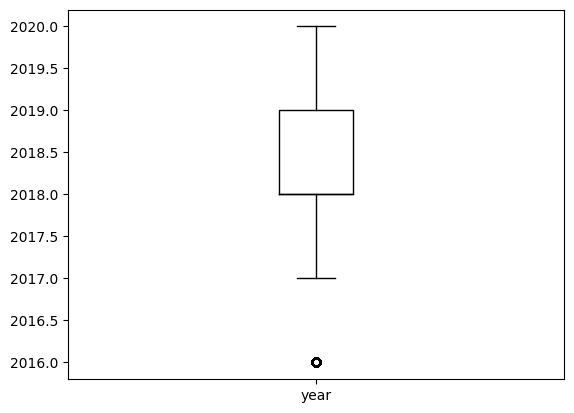

In [ ]:
merged_data.boxplot(column=['year'], grid=False, color='black')

<Axes: >

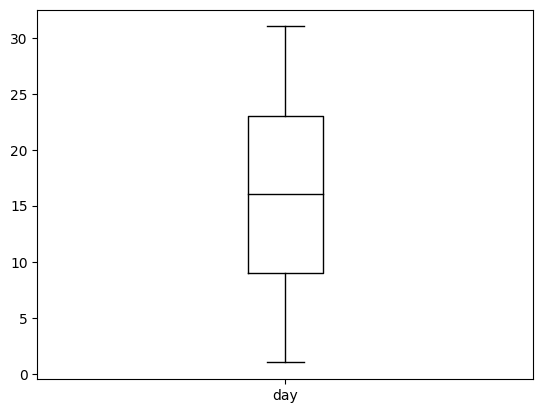

In [ ]:
merged_data.boxplot(column=['day'], grid=False, color='black')

<Axes: >

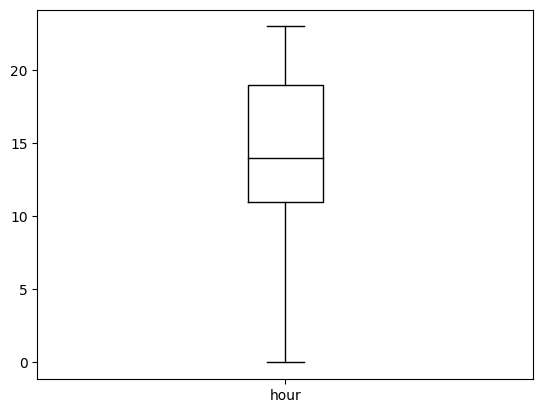

In [ ]:
merged_data.boxplot(column=['hour'], grid=False, color='black')

<Axes: >

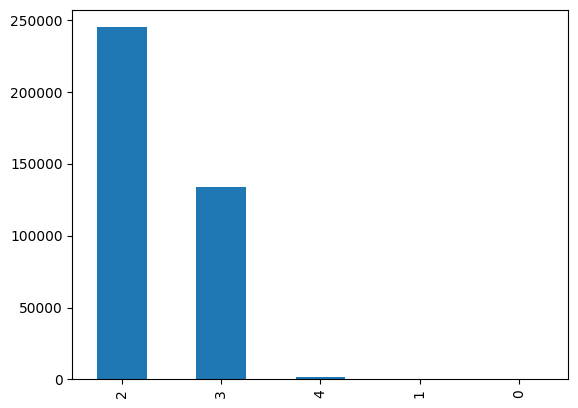

In [ ]:
merged_data['Severity'].value_counts().plot.bar()

We can see the maximum data is of severity 2 that is moderate severe and less delay in traffic during most of the accident

<Axes: >

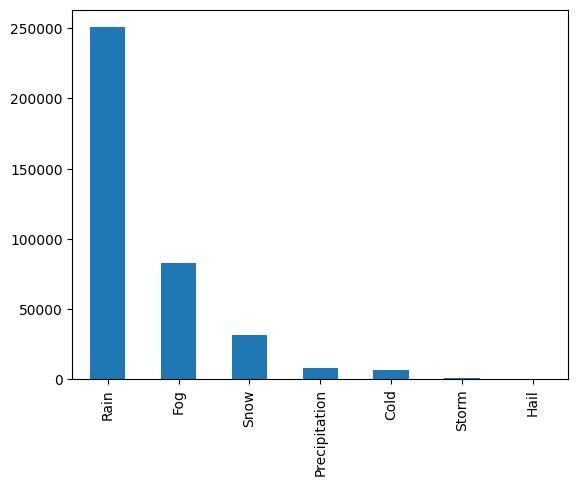

In [ ]:
merged_data['Weather_Type'].value_counts().plot.bar()

As per the merged data, most of the accident occured during Rain followed by Fog type of weather.

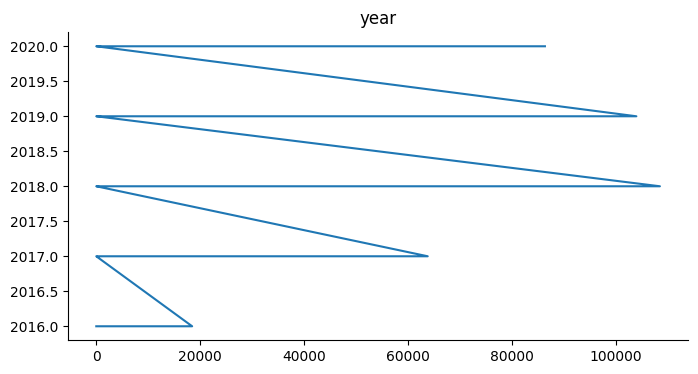

In [ ]:
from matplotlib import pyplot as plt
merged_data['year'].plot(kind='line', figsize=(8, 4), title='year')
plt.gca().spines[['top', 'right']].set_visible(False)

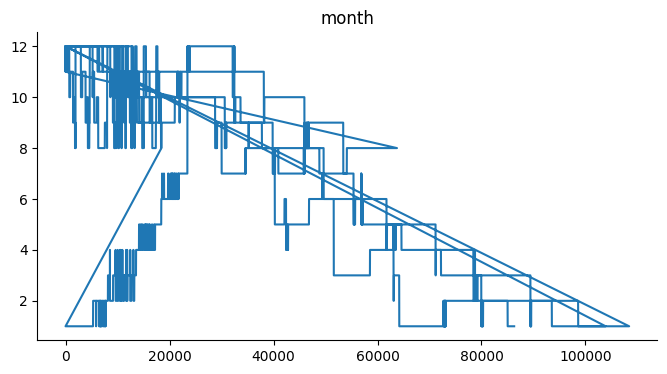

In [ ]:
from matplotlib import pyplot as plt
merged_data['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

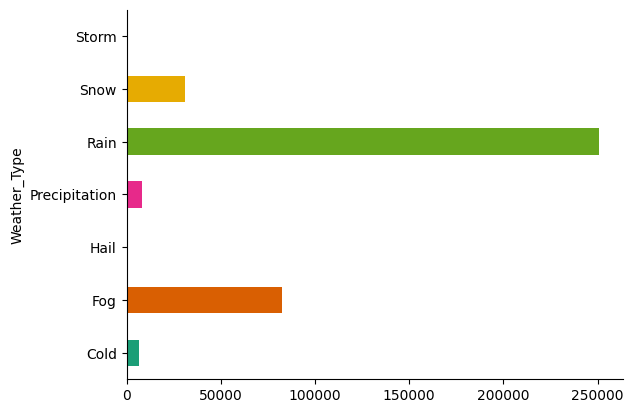

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Weather_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

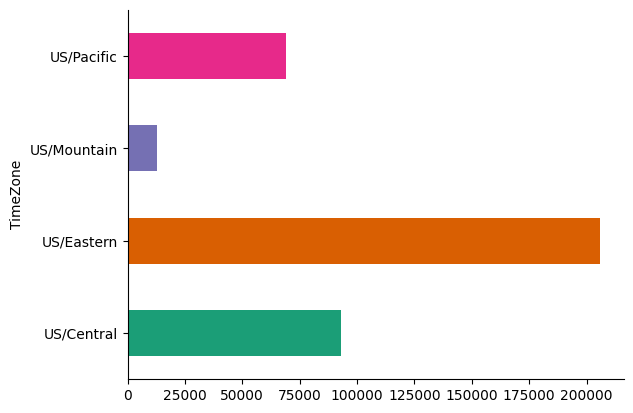

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('TimeZone').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

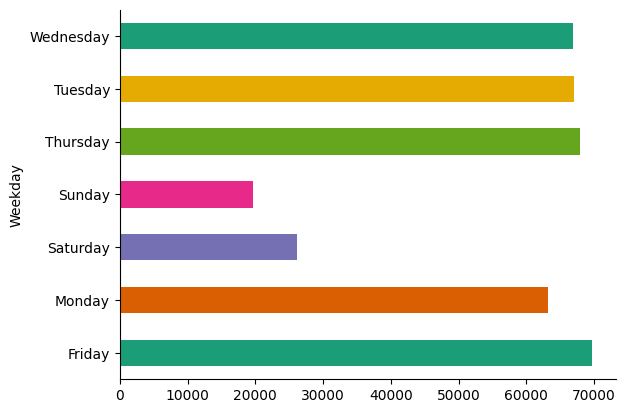

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Weekday').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

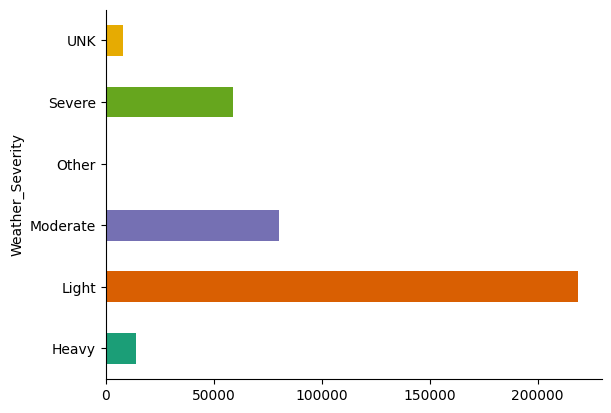

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Weather_Severity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

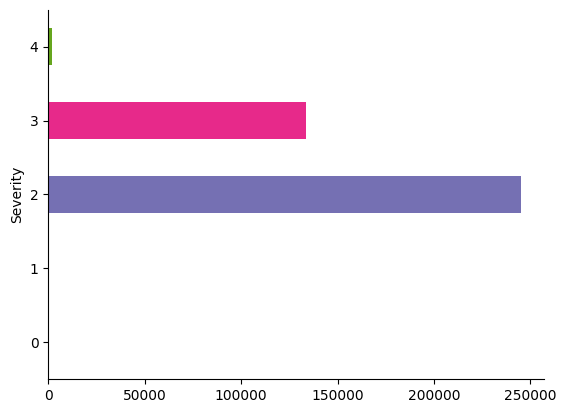

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Severity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Checking skewness of Data

In [ ]:
merged_data.skew(axis = 0, skipna = True)

Severity       0.688091
LocationLat    0.208158
LocationLng   -0.987784
ZipCode        0.460071
month         -0.132720
year          -0.265654
day            0.025013
hour          -0.655123
minute        -0.018710
second        -0.004244
dtype: float64

In [ ]:
merged_data.skew(axis = 1, skipna = True)

0        3.159672
1        3.159671
2        3.159593
3        3.159625
4        3.159625
           ...   
86281    3.159753
86282    3.159753
86283    3.159753
86284    3.159753
86285    3.159753
Length: 380746, dtype: float64

**Bivariate Analysis**

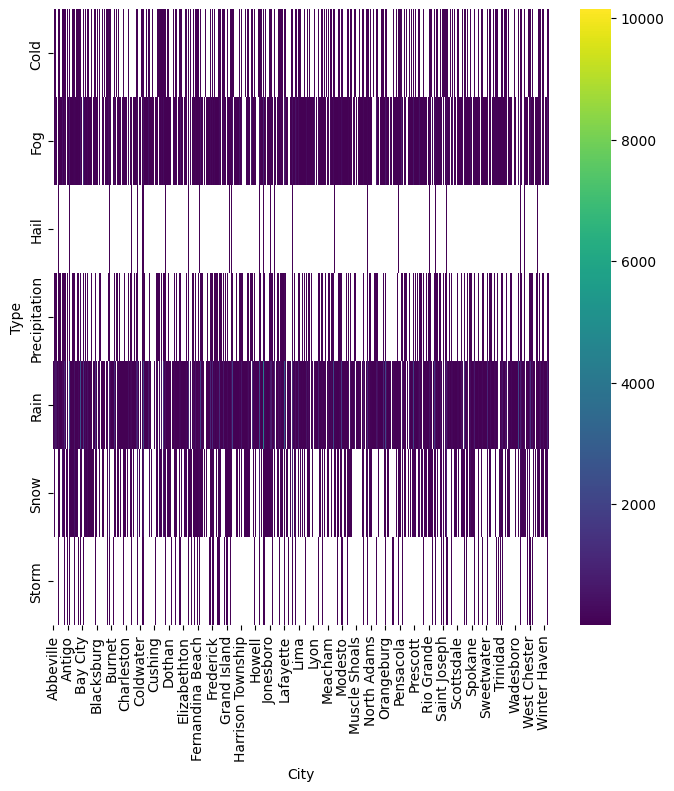

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Weather_Type'].value_counts()
    for x_label, grp in merged_data.groupby('City')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('City')
_ = plt.ylabel('Type')

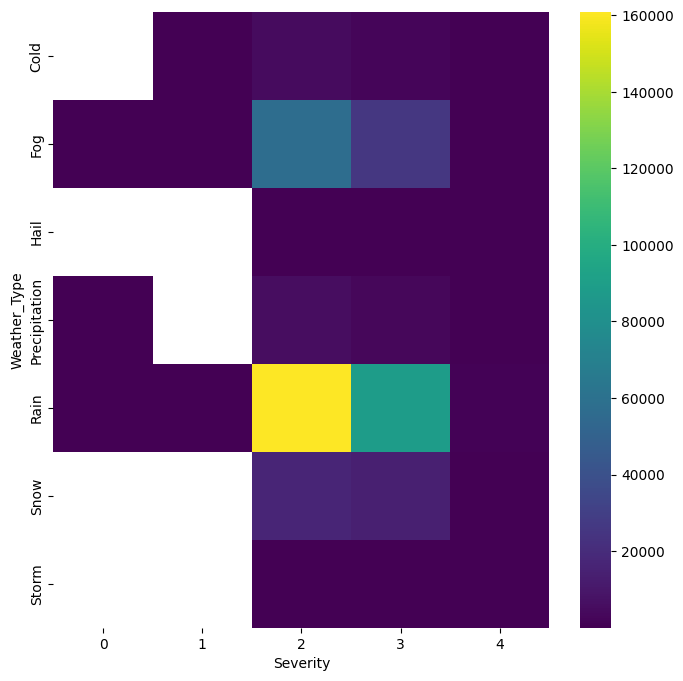

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Weather_Type'].value_counts()
    for x_label, grp in merged_data.groupby('Severity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Severity')
_ = plt.ylabel('Weather_Type')

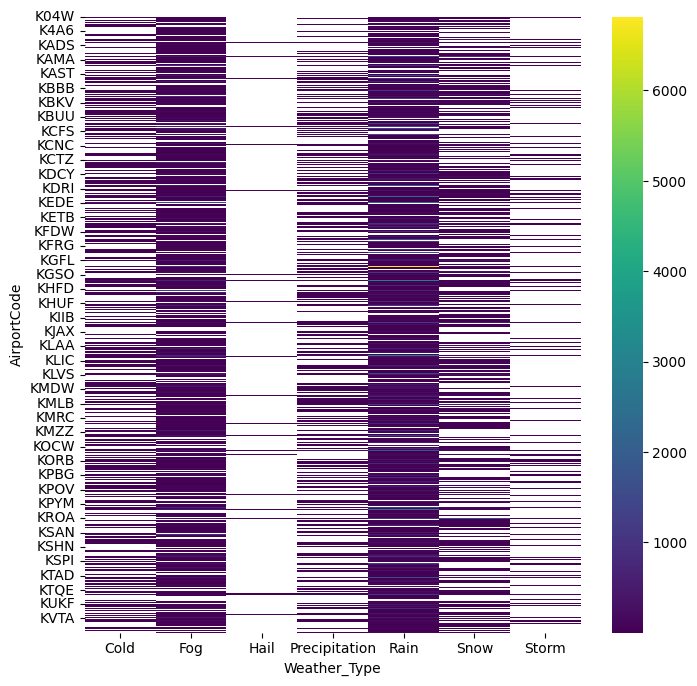

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['AirportCode'].value_counts()
    for x_label, grp in merged_data.groupby('Weather_Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Weather_Type')
_ = plt.ylabel('AirportCode')

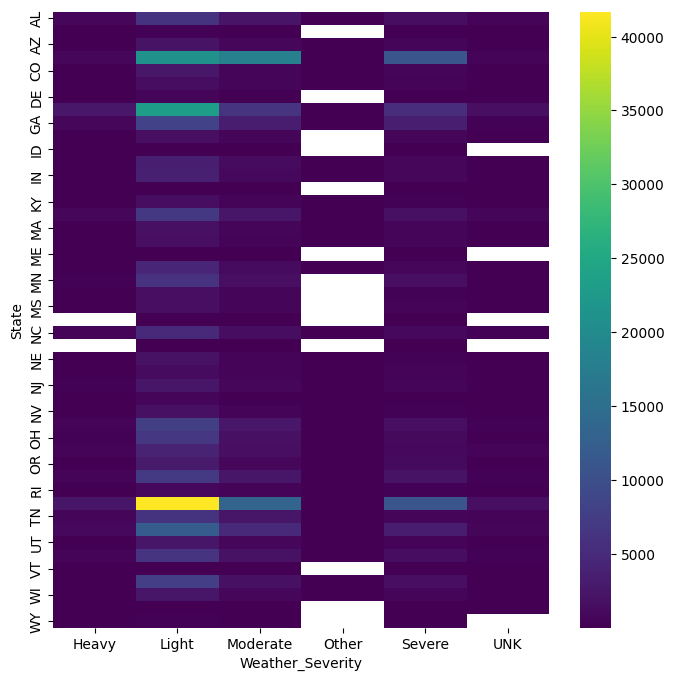

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['State'].value_counts()
    for x_label, grp in merged_data.groupby('Weather_Severity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Weather_Severity')
_ = plt.ylabel('State')

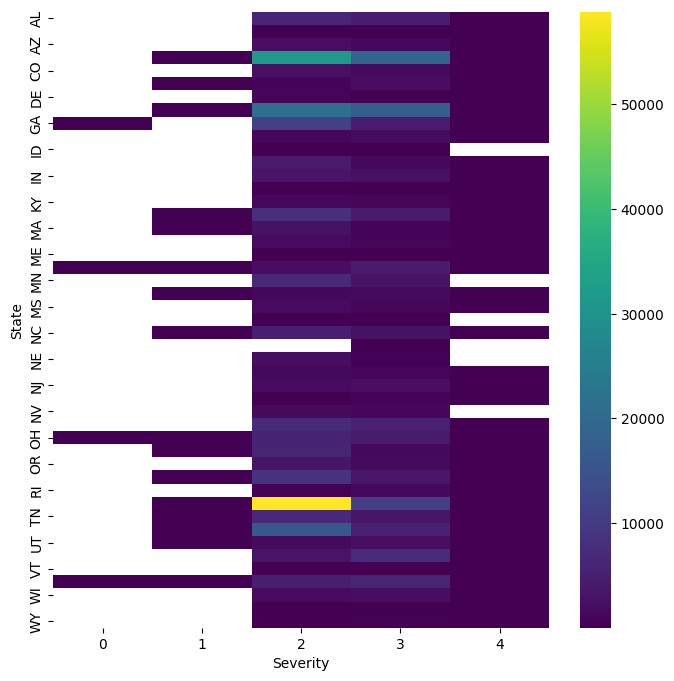

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['State'].value_counts()
    for x_label, grp in merged_data.groupby('Severity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Severity')
_ = plt.ylabel('State')

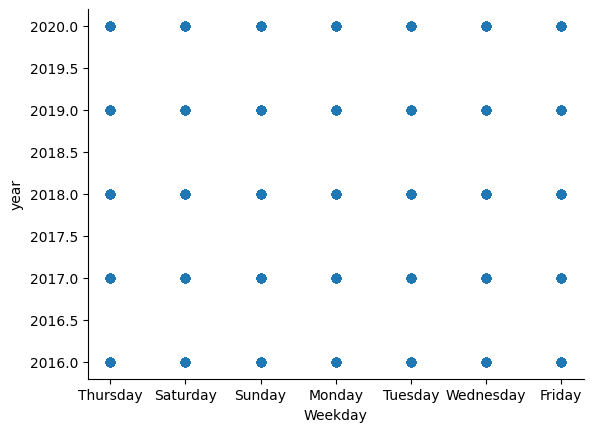

In [ ]:
from matplotlib import pyplot as plt
merged_data.plot(kind='scatter', x='Weekday', y='year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Weekday'>

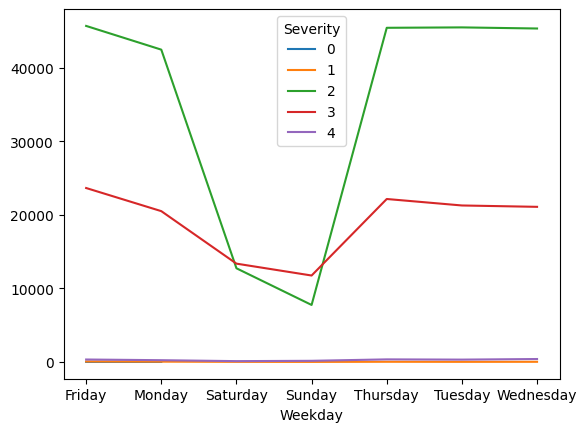

In [ ]:
merged_data.groupby(['Weekday', 'Severity']).size().unstack().plot()


<Axes: xlabel='Severity,Weather_Type'>

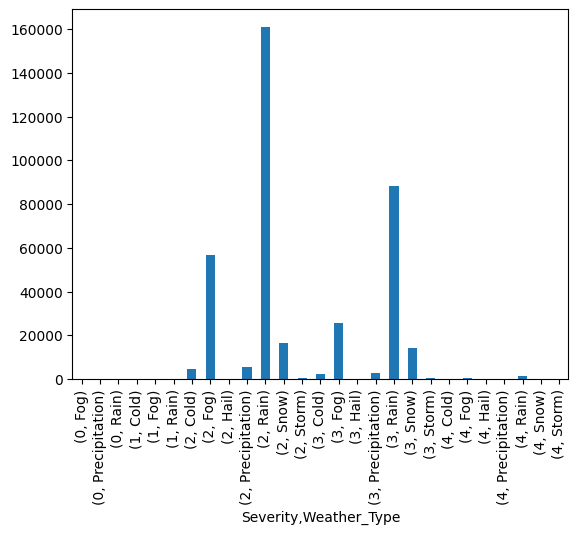

In [ ]:

merged_data.groupby(['Severity', 'Weather_Type']).size().plot(kind='bar')


<Axes: xlabel='Weather_Type', ylabel='Severity'>

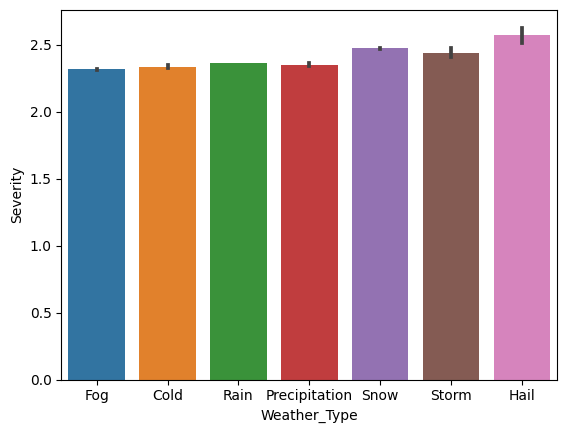

In [ ]:
import seaborn as sns
sns.barplot(x="Weather_Type", y="Severity", data=merged_data)

**MultiVariate Analysis**

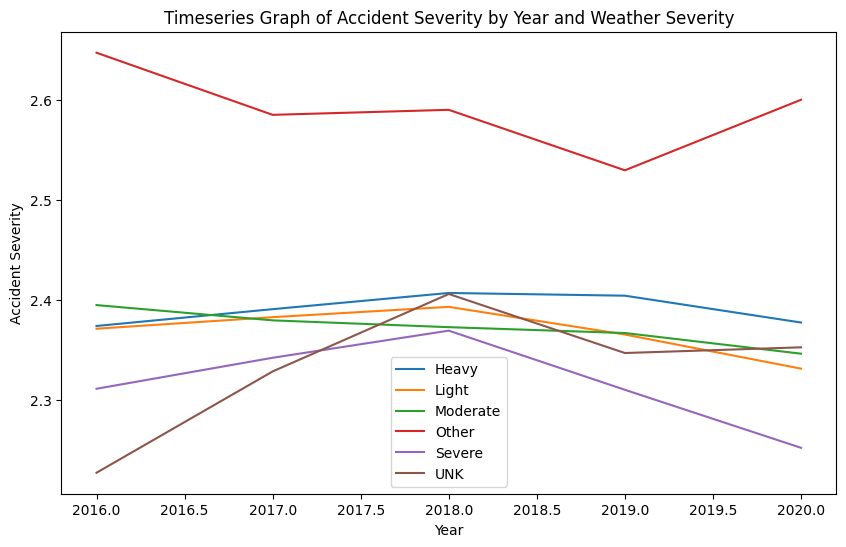

In [ ]:
# Convert the date column to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Group the data by year and weather severity
grouped_df = merged_data.groupby(['year', 'Weather_Severity'])

# Calculate the mean accident severity for each group
mean_accident_severity = grouped_df['Severity'].mean()

# Reshape the mean_accident_severity DataFrame into a format that can be plotted
mean_accident_severity_unstacked = mean_accident_severity.unstack()

# Convert the column names to strings
mean_accident_severity_unstacked.columns = mean_accident_severity_unstacked.columns.astype(str)

# Sort the columns by year
mean_accident_severity_unstacked = mean_accident_severity_unstacked.sort_index(level=['year'], axis=1)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the lines for each weather severity
for weather_severity in mean_accident_severity_unstacked.columns:
    line = mean_accident_severity_unstacked[weather_severity].plot(ax=ax, label=weather_severity)

# Set the title and labels
ax.set_title('Timeseries Graph of Accident Severity by Year and Weather Severity')
ax.set_xlabel('Year')
ax.set_ylabel('Accident Severity')

# Add a legend
ax.legend()

# Show the plot
plt.show()



Plotting the latitude and longitude on map for Analysis

In [ ]:
import pandas as pd
import folium

# Create a Folium map object
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Iterate over the DataFrame and add a marker to the map for each latitude and longitude
for i, row in merged_data.iterrows():
    folium.CircleMarker(location=[row['LocationLat'], row['LocationLng']], radius=10, color='red').add_to(map)

# Save the map to an HTML file
map.save('/content/drive/MyDrive/Colab Notebooks/accident_locations_map_merged.html')


In [ ]:
import folium

# Create a Map instance
m = folium.Map(location=[37.0902, -95.7129],
    zoom_start=12, control_scale=True)

# Iterate over the DataFrame and add a marker to the map for each latitude and longitude
for i, row in merged_data.iterrows():
    city = row['City']
    severity = row['Severity']
    weather_type = row['Weather_Type']
    weather_severity = row['Weather_Severity']

    popup_message = f"City: {city}\nSeverity: {severity}\nWeather Type: {weather_type}\nWeather Severity: {weather_severity}"

    folium.Marker(location=[row['LocationLat'], row['LocationLng']], popup=popup_message, icon=folium.Icon(color='red', icon='ok-sign')).add_to(m)

# Save the map to an HTML file
m.save('/content/drive/MyDrive/Colab Notebooks/accident_locations_map_merged_new.html')

In [ ]:
merged_data.head()

,Severity,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,AirportCode,City,State,ZipCode,Weekday,month,year,date,Weather_Type,Weather_Severity,day,hour,minute,second
0,2,2016-12-01 03:38:32,2016-12-01 04:08:21,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,2016-12-01,Fog,Severe,1,3,38,32
1,2,2016-12-01 03:57:44,2016-12-01 04:27:26,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,2016-12-01,Fog,Moderate,1,3,57,44
2,2,2016-12-01 05:13:53,2016-12-01 05:43:53,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,2016-12-01,Cold,Severe,1,5,13,53
3,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe,1,19,34,31
4,2,2016-12-01 19:34:31,2016-12-01 20:03:44,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,2016-12-01,Fog,Severe,1,19,34,31


Removing Unneccessary columns

In [ ]:
merged_data = merged_data.drop('StartTime(UTC)', axis=1)

In [ ]:
merged_data = merged_data.drop('EndTime(UTC)', axis=1)

In [ ]:
merged_data = merged_data.drop('date', axis=1)

In [ ]:
print(list(merged_data.columns))

['Severity', 'TimeZone', 'LocationLat', 'LocationLng', 'AirportCode', 'City', 'State', 'ZipCode', 'Weekday', 'month', 'year', 'Weather_Type', 'Weather_Severity', 'day', 'hour', 'minute', 'second']


For less memory usage reducing the datatype to 32 bits from 64 bits

In [ ]:
# Example: Convert int64 columns to int32

merged_data['ZipCode'] = merged_data['ZipCode'].astype('int32')
merged_data['month'] = merged_data['month'].astype('int32')
merged_data['year'] = merged_data['year'].astype('int32')
merged_data['day'] = merged_data['day'].astype('int32')
merged_data['hour'] = merged_data['hour'].astype('int32')
merged_data['minute'] = merged_data['minute'].astype('int32')
merged_data['second'] = merged_data['second'].astype('int32')


# Convert object to category
object_columns = merged_data.select_dtypes(include=['object']).columns
merged_data[object_columns] = merged_data[object_columns].astype('category')


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Severity          380746 non-null  int64   
 1   TimeZone          380746 non-null  category
 2   LocationLat       380746 non-null  float64 
 3   LocationLng       380746 non-null  float64 
 4   AirportCode       380746 non-null  category
 5   City              380746 non-null  category
 6   State             380746 non-null  category
 7   ZipCode           380746 non-null  int32   
 8   Weekday           380746 non-null  category
 9   month             380746 non-null  int32   
 10  year              380746 non-null  int32   
 11  Weather_Type      380746 non-null  category
 12  Weather_Severity  380746 non-null  category
 13  day               380746 non-null  int32   
 14  hour              380746 non-null  int32   
 15  minute            380746 non-null  int32   
 16  sec

Relationship between numerical variables

In [ ]:
cat_data_corr=merged_data.corr()
cat_data_corr

,Severity,LocationLat,LocationLng,ZipCode,month,year,day,hour,minute,second
Severity,1.000000,0.076810,-0.029904,0.017891,-0.020010,-0.038871,0.004826,-0.004768,-0.007354,0.010111
LocationLat,0.076810,1.000000,-0.185469,0.110314,-0.031661,-0.006336,0.010438,-0.030713,0.000783,-0.000080
LocationLng,-0.029904,-0.185469,1.000000,-0.954270,0.041519,0.054151,0.012190,0.079979,-0.002541,0.009025
ZipCode,0.017891,0.110314,-0.954270,1.000000,-0.035810,-0.061598,-0.007775,-0.069475,0.001587,-0.009670
month,-0.020010,-0.031661,0.041519,-0.035810,1.000000,-0.193867,0.047202,0.020354,-0.001475,0.006274
year,-0.038871,-0.006336,0.054151,-0.061598,-0.193867,1.000000,0.023785,-0.010425,-0.007516,-0.008579
day,0.004826,0.010438,0.012190,-0.007775,0.047202,0.023785,1.000000,0.004499,0.000226,0.002648
hour,-0.004768,-0.030713,0.079979,-0.069475,0.020354,-0.010425,0.004499,1.000000,-0.000794,-0.008262
minute,-0.007354,0.000783,-0.002541,0.001587,-0.001475,-0.007516,0.000226,-0.000794,1.000000,0.001376
second,0.010111,-0.000080,0.009025,-0.009670,0.006274,-0.008579,0.002648,-0.008262,0.001376,1.000000


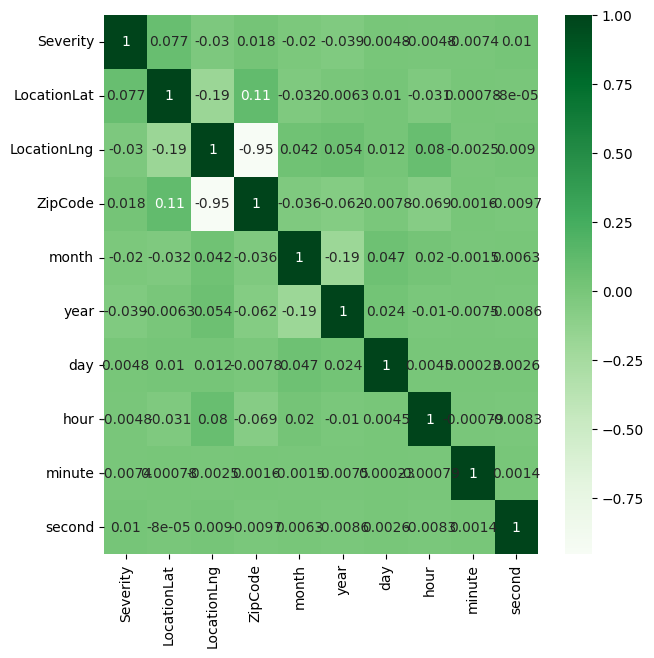

In [ ]:
plt.figure(figsize=[7,7])
sns.heatmap(cat_data_corr,annot=True,cmap='Greens')
plt.show()

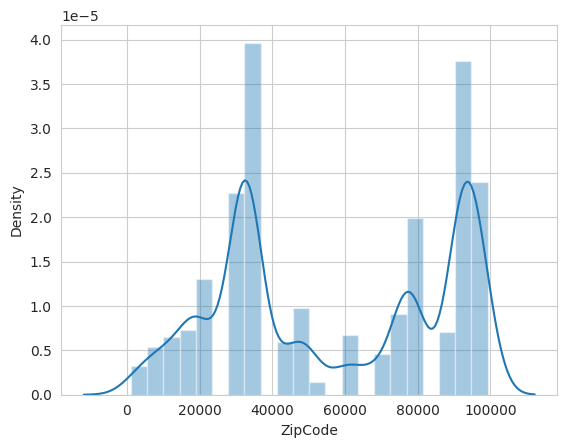

In [ ]:
sns.set_style('whitegrid')
sns.distplot(merged_data['ZipCode'])
plt.show()

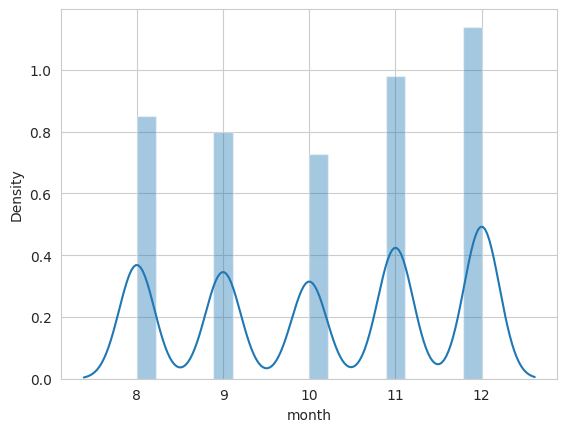

In [ ]:
sns.set_style('whitegrid')
sns.distplot(merged_data['month'])
plt.show()

Checking the unique value percentage for categorical variables

In [ ]:
merged_data['TimeZone'].value_counts(normalize=True)*100

US/Eastern     54.060975
US/Central     24.453573
US/Pacific     18.131510
US/Mountain     3.353942
Name: TimeZone, dtype: float64

In [ ]:
merged_data['AirportCode'].value_counts(normalize=True)*100

KGMU    2.103765
KAGS    1.985838
KBNA    1.471322
KGSP    1.353658
KEDC    1.117018
          ...   
KHDN    0.000263
KDFI    0.000263
KCCY    0.000263
KLNK    0.000263
KPCW    0.000263
Name: AirportCode, Length: 1376, dtype: float64

In [ ]:
merged_data['Weekday'].value_counts(normalize=True)*100

Friday       18.313784
Thursday     17.849432
Tuesday      17.620671
Wednesday    17.556849
Monday       16.610549
Saturday      6.886481
Sunday        5.162234
Name: Weekday, dtype: float64

In [ ]:
merged_data['Weather_Type'].value_counts(normalize=True)*100

Rain             65.852563
Fog              21.695566
Snow              8.213087
Precipitation     2.148414
Cold              1.740005
Storm             0.261592
Hail              0.088773
Name: Weather_Type, dtype: float64

In [ ]:
merged_data['Weather_Severity'].value_counts(normalize=True)*100

Light       57.455889
Moderate    21.097004
Severe      15.491167
Heavy        3.718752
UNK          2.148414
Other        0.088773
Name: Weather_Severity, dtype: float64

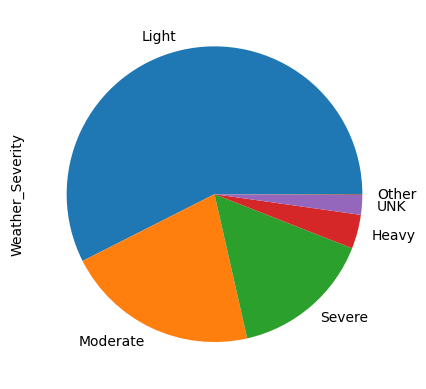

In [ ]:
merged_data['Weather_Severity'].value_counts().plot.pie()
plt.show()

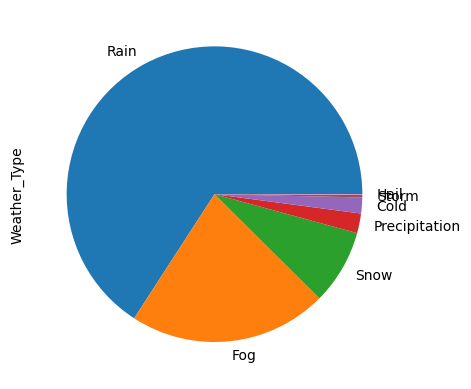

In [ ]:
merged_data['Weather_Type'].value_counts().plot.pie()
plt.show()

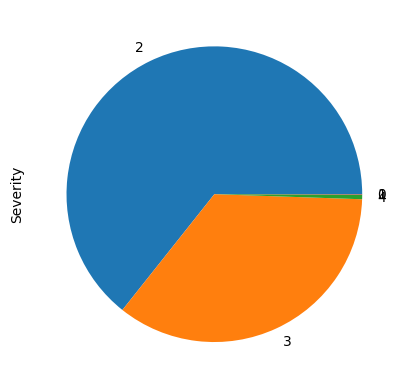

In [ ]:
merged_data['Severity'].value_counts().plot.pie()
plt.show()

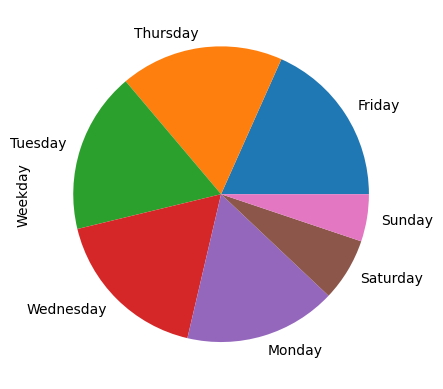

In [ ]:
merged_data['Weekday'].value_counts().plot.pie()
plt.show()

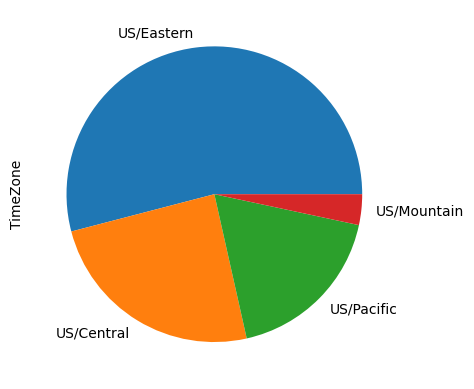

In [ ]:
merged_data['TimeZone'].value_counts().plot.pie()
plt.show()

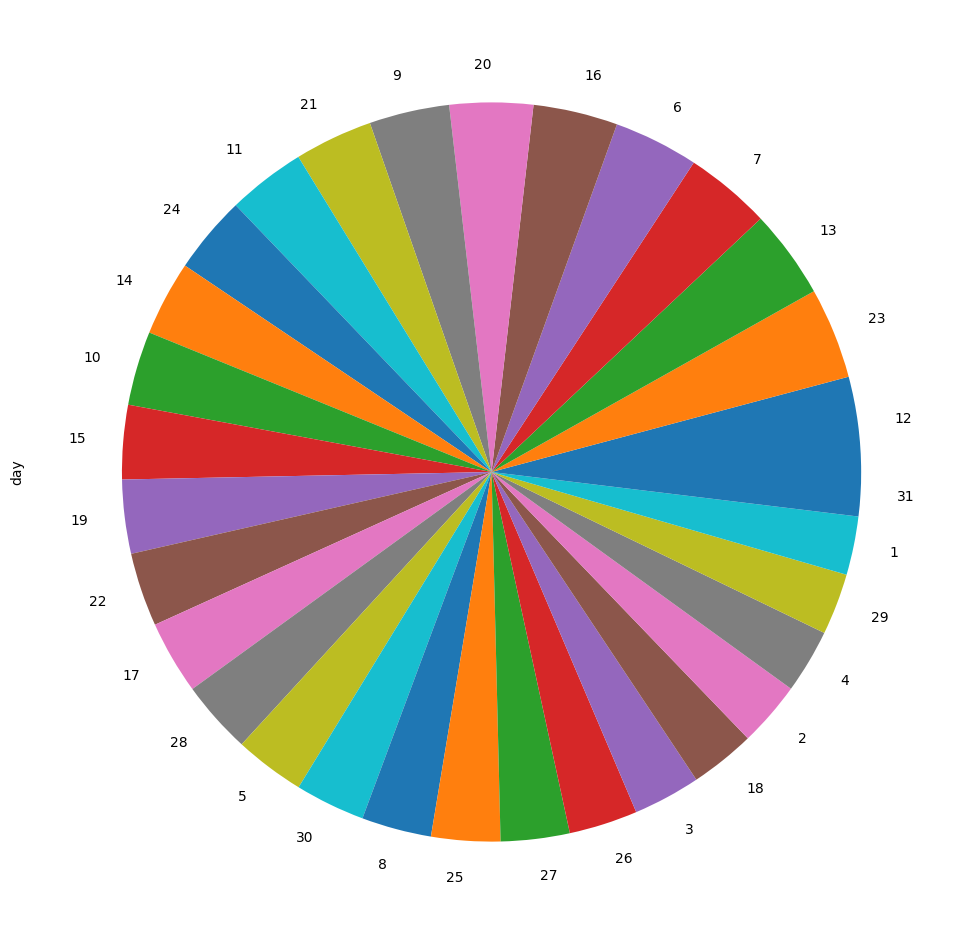

In [ ]:
merged_data['day'].value_counts().plot.pie()
plt.show()

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Severity          380746 non-null  int64   
 1   TimeZone          380746 non-null  category
 2   LocationLat       380746 non-null  float64 
 3   LocationLng       380746 non-null  float64 
 4   AirportCode       380746 non-null  category
 5   City              380746 non-null  category
 6   State             380746 non-null  category
 7   ZipCode           380746 non-null  int32   
 8   Weekday           380746 non-null  category
 9   month             380746 non-null  int32   
 10  year              380746 non-null  int32   
 11  Weather_Type      380746 non-null  category
 12  Weather_Severity  380746 non-null  category
 13  day               380746 non-null  int32   
 14  hour              380746 non-null  int32   
 15  minute            380746 non-null  int32   
 16  sec

In [ ]:
merged_data.head()


,Severity,TimeZone,LocationLat,LocationLng,AirportCode,City,State,ZipCode,Weekday,month,year,Weather_Type,Weather_Severity,day,hour,minute,second
0,2,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,Fog,Severe,1,3,38,32
1,2,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,Fog,Moderate,1,3,57,44
2,2,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,Cold,Severe,1,5,13,53
3,2,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,Fog,Severe,1,19,34,31
4,2,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,Fog,Severe,1,19,34,31


from matplotlib import pyplot as plt
_df_12['LocationLat'].plot(kind='hist', bins=20, title='LocationLat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['LocationLng'].plot(kind='hist', bins=20, title='LocationLng')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['ZipCode'].plot(kind='hist', bins=20, title='ZipCode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['hour'].plot(kind='hist', bins=20, title='hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='LocationLat', y='LocationLng', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='LocationLng', y='ZipCode', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='ZipCode', y='hour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='hour', y='minute', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Severity']
  ys = series['LocationLat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_20.sort_values('Severity', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Severity')
_ = plt.ylabel('LocationLat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Severity']
  ys = series['LocationLng']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('Severity', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Severity')
_ = plt.ylabel('LocationLng')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Severity']
  ys = series['ZipCode']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('Severity', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Severity')
_ = plt.ylabel('ZipCode')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Severity']
  ys = series['minute']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('Severity', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Severity')
_ = plt.ylabel('minute')

from matplotlib import pyplot as plt
_df_24['LocationLat'].plot(kind='line', figsize=(8, 4), title='LocationLat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['LocationLng'].plot(kind='line', figsize=(8, 4), title='LocationLng')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['ZipCode'].plot(kind='line', figsize=(8, 4), title='ZipCode')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['hour'].plot(kind='line', figsize=(8, 4), title='hour')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
merged_data_dummy = merged_data.copy()

In [ ]:
merged_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Severity          380746 non-null  int64   
 1   TimeZone          380746 non-null  category
 2   LocationLat       380746 non-null  float64 
 3   LocationLng       380746 non-null  float64 
 4   AirportCode       380746 non-null  category
 5   City              380746 non-null  category
 6   State             380746 non-null  category
 7   ZipCode           380746 non-null  int32   
 8   Weekday           380746 non-null  category
 9   month             380746 non-null  int32   
 10  year              380746 non-null  int32   
 11  Weather_Type      380746 non-null  category
 12  Weather_Severity  380746 non-null  category
 13  day               380746 non-null  int32   
 14  hour              380746 non-null  int32   
 15  minute            380746 non-null  int32   
 16  sec

In [ ]:
import plotly.graph_objects as go

def plot_categorical_variable(dataframe, variable_name, variable_description):
  # In order to plot, we transform our Spark dataframe into a Pandas dataframe
  # https://datascience.stackexchange.com/questions/37880/plotting-in-pyspark
  #dataframe = dataframe.select(variable_name).toPandas()

  labels = dataframe[variable_name].value_counts().index
  values = dataframe[variable_name].value_counts().values

  # Bars plot
  fig = go.Figure(go.Bar(x=labels, y=values, name=""), layout=go.Layout(
          title=go.layout.Title(text="Total number of "+variable_description),
          xaxis=dict(type="category")
      ))
  fig.show()

  # Donut plot
  fig = go.Figure(go.Pie(labels=labels, values=values, hole=.5, name=""), layout=go.Layout(
          title=go.layout.Title(text="Percentage of "+variable_description)
      ))
  fig.show()

def compute_numerical_variable_statistics(dataframe, variable_name):
  dataframe.describe(variable_name).show()

In [ ]:
plot_categorical_variable(merged_data_dummy, "Severity", "accidents per severity")

In [ ]:
plot_categorical_variable(merged_data_dummy, "State", "accidents per state")

In [ ]:
# Filter the data to only include rows where the state is SC
df_filtered = merged_data_dummy[merged_data_dummy['State'] == 'SC']

# Get the weather type and weekday variables
weather_type = df_filtered['Weather_Type']
weekday = df_filtered['Weekday']

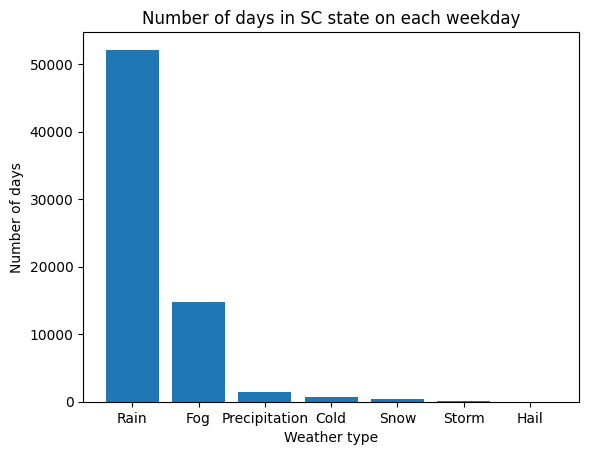

In [ ]:
import matplotlib.pyplot as plt

weather_type_counts = df_filtered['Weather_Type'].value_counts()
weekday_counts = df_filtered['Weekday'].value_counts()

# Create a bar chart
plt.bar(weather_type_counts.index, weather_type_counts.values)
plt.xlabel('Weather type')
plt.ylabel('Number of days')
plt.title('Number of days in South Carolina on each weekday')
plt.show()

In [ ]:
plot_categorical_variable(merged_data_dummy, "Weather_Type", "accidents per Weather_Type")

In [ ]:
plot_categorical_variable(merged_data_dummy, "Weather_Severity", "accidents per Weather_Severity")

In [ ]:
plot_categorical_variable(merged_data_dummy, "Weekday", "accidents per Weekday")

In [ ]:
plot_categorical_variable(merged_data_dummy, "City", "accidents per City")

In [ ]:
plot_categorical_variable(merged_data_dummy, "TimeZone", "accidents per TimeZone")

Converting categorical variables into dummies

In [ ]:
merged_data_dummy.head()

,Severity,TimeZone,LocationLat,LocationLng,AirportCode,City,State,ZipCode,Weekday,month,year,Weather_Type,Weather_Severity,day,hour,minute,second
0,2,US/Pacific,39.169224,-123.21139,KUKI,Ukiah,CA,95482,Thursday,12,2016,Fog,Severe,1,3,38,32
1,2,US/Pacific,37.371304,-120.61373,KMER,Atwater,CA,95301,Thursday,12,2016,Fog,Moderate,1,3,57,44
2,2,US/Pacific,37.500683,-122.24131,KSQL,San Carlos,CA,94070,Thursday,12,2016,Cold,Severe,1,5,13,53
3,2,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,Fog,Severe,1,19,34,31
4,2,US/Pacific,38.243504,-122.26866,KAPC,Napa,CA,94558,Thursday,12,2016,Fog,Severe,1,19,34,31


In [ ]:
cat_columns = ['TimeZone','Weekday', 'Weather_Type', 'Weather_Severity','City','State']

# Create dummy variables for the categorical columns
dummy_variables = []
for column in cat_columns:
    dummy_variables.append(pd.get_dummies(merged_data_dummy[column], prefix=column))

# Concatenate the dummy variables to the merged_data DataFrame
merged_data_dummy = pd.concat([merged_data_dummy] + dummy_variables, axis=1)

# Drop the original categorical columns from the merged_data DataFrame
merged_data_dummy = merged_data_dummy.drop(cat_columns, axis=1)


In [ ]:
merged_data_dummy.head()

,Severity,LocationLat,LocationLng,AirportCode,ZipCode,month,year,day,hour,minute,...,State_SC,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,2,39.169224,-123.21139,KUKI,95482,12,2016,1,3,38,...,0,0,0,0,0,0,0,0,0,0
1,2,37.371304,-120.61373,KMER,95301,12,2016,1,3,57,...,0,0,0,0,0,0,0,0,0,0
2,2,37.500683,-122.24131,KSQL,94070,12,2016,1,5,13,...,0,0,0,0,0,0,0,0,0,0
3,2,38.243504,-122.26866,KAPC,94558,12,2016,1,19,34,...,0,0,0,0,0,0,0,0,0,0
4,2,38.243504,-122.26866,KAPC,94558,12,2016,1,19,34,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Columns: 1251 entries, Severity to State_WY
dtypes: category(1), float64(2), int32(7), int64(1), uint8(1240)
memory usage: 472.8 MB


In [ ]:
merged_data_dummy['AirportCode'].unique()

['KUKI', 'KMER', 'KSQL', 'KAPC', 'KHAF', ..., 'K4BM', 'KAJZ', 'KAFK', 'KGJT', 'KERV']
Length: 1376
Categories (1376, object): ['K04W', 'K0A9', 'K0E0', 'K11R', ..., 'KYIP', 'KYNG', 'KZPH', 'KZZV']

In [ ]:
merged_data_dummy['City'].unique()

['Ukiah', 'Atwater', 'San Carlos', 'Napa', 'Half Moon Bay', ..., 'McGregor', 'Lake George', 'Nebraska City', 'Grand Junction', 'Kerrville']
Length: 1169
Categories (1169, object): ['Abbeville', 'Abilene', 'Abingdon', 'Accident', ..., 'Yuma', 'Zanesville',
                            'Zephyrhills', 'Zionsville']

In [ ]:
merged_data_dummy['State'].unique()

['CA', 'FL', 'GA', 'SC', 'NE', ..., 'AR', 'KS', 'ME', 'ND', 'MT']
Length: 47
Categories (47, object): ['AL', 'AR', 'AZ', 'CA', ..., 'WA', 'WI', 'WV', 'WY']

Dropping columns with more than 1000 unique values and considering City and State as better approach

In [ ]:
merged_data_dummy.drop('AirportCode', axis=1, inplace=True)
merged_data_dummy.drop('ZipCode', axis=1, inplace=True)
merged_data_dummy.head()


,Severity,LocationLat,LocationLng,month,year,day,hour,minute,second,TimeZone_US/Central,...,State_SC,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,2,39.169224,-123.21139,12,2016,1,3,38,32,0,...,0,0,0,0,0,0,0,0,0,0
1,2,37.371304,-120.61373,12,2016,1,3,57,44,0,...,0,0,0,0,0,0,0,0,0,0
2,2,37.500683,-122.24131,12,2016,1,5,13,53,0,...,0,0,0,0,0,0,0,0,0,0
3,2,38.243504,-122.26866,12,2016,1,19,34,31,0,...,0,0,0,0,0,0,0,0,0,0
4,2,38.243504,-122.26866,12,2016,1,19,34,31,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380746 entries, 0 to 86285
Columns: 1249 entries, Severity to State_WY
dtypes: float64(2), int32(6), int64(1), uint8(1240)
memory usage: 470.6 MB


In [ ]:

merged_data_dummy.to_csv('/content/drive/MyDrive/Colab Notebooks/merged_data_dummy.csv', index=False)


In [ ]:
merged_data_dummy_backup = merged_data_dummy.copy()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

vars=['Severity', 'LocationLat', 'LocationLng', 'month','year','day','hour','minute','second']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale all of the dummy variables
#merged_scaler = scaler.fit_transform(merged_data_dummy_backup)
merged_data_dummy_backup[vars]=scaler.fit_transform(merged_data_dummy_backup[vars])
merged_data_dummy_backup.head()

,Severity,LocationLat,LocationLng,month,year,day,hour,minute,second,TimeZone_US/Central,...,State_SC,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.5,0.601183,0.023336,1.0,0.0,0.0,0.130435,0.644068,0.542373,0,...,0,0,0,0,0,0,0,0,0,0
1,0.5,0.527210,0.069155,1.0,0.0,0.0,0.130435,0.966102,0.745763,0,...,0,0,0,0,0,0,0,0,0,0
2,0.5,0.532533,0.040447,1.0,0.0,0.0,0.217391,0.220339,0.898305,0,...,0,0,0,0,0,0,0,0,0,0
3,0.5,0.563095,0.039965,1.0,0.0,0.0,0.826087,0.576271,0.525424,0,...,0,0,0,0,0,0,0,0,0,0
4,0.5,0.563095,0.039965,1.0,0.0,0.0,0.826087,0.576271,0.525424,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = merged_data_dummy_backup.drop('Severity', axis=1)
y = merged_data_dummy_backup['Severity']
print(len(X))
print(len(y))
# Get the lengths of the X and y arrays
X_len = len(X)
y_len = len(y)

# Remove the extra values from the longer array
if X_len > y_len:
    X = X[:y_len]
elif X_len < y_len:
    y = y[:X_len]

print(len(X))
print(len(y))

380746
380746
380746
380746


Class=0, n=244885 (64.317%)
Class=0, n=133782 (35.137%)
Class=0, n=172 (0.045%)
Class=1, n=1891 (0.497%)
Class=0, n=16 (0.004%)


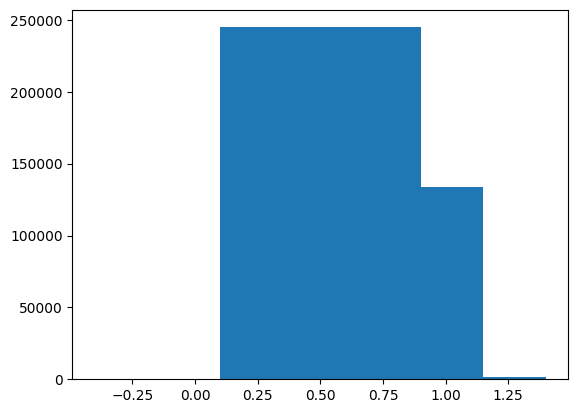

In [ ]:
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
print(merged_data_dummy_backup['Severity'].value_counts(normalize=True))

0.50    0.643172
0.75    0.351368
1.00    0.004967
0.25    0.000452
0.00    0.000042
Name: Severity, dtype: float64


In [ ]:
merged_data_undersample = merged_data_dummy_backup.copy()

In [ ]:
merged_data_undersample.drop(merged_data_undersample[(merged_data_undersample['Severity'] == 0.25) | (merged_data_undersample['Severity'] == 0.00)].index, inplace=True)

In [ ]:
print(merged_data_undersample['Severity'].value_counts(normalize=True))

0.50    0.643474
0.75    0.351557
1.00    0.004969
Name: Severity, dtype: float64


In [ ]:
X_1 = merged_data_undersample.drop('Severity', axis=1)
y_1 = merged_data_undersample['Severity']

Class=0, n=244477 (64.347%)
Class=0, n=133568 (35.156%)
Class=1, n=1888 (0.497%)


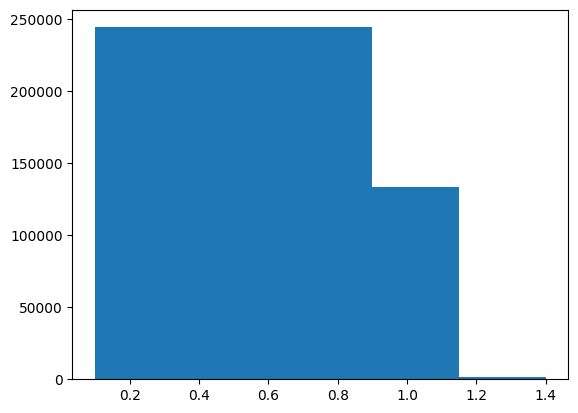

In [ ]:
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# summarize distribution
counter = Counter(y_1)
for k,v in counter.items():
 per = v / len(y_1) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()
X_2, y_2= undersample.fit_resample(X_1,y_1)
# summarize distribution
counter = Counter(y_2)
for k,v in counter.items():
 per = v / len(y_2) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a CatBoostRegressor object
model = CatBoostRegressor()

# Fit the RFE object to the train data
rfe = RFE(estimator=model, n_features_to_select=100)
rfe.fit(X_train, y_train)

# Select the features that were not eliminated by the RFE object
selected_features = X_train.columns[rfe.support_]

# Fit the model to the train data using the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test data
y_pred = model.predict(X_test[selected_features])




Streaming output truncated to the last 5000 lines.
4:	learn: 0.4737823	total: 54.4ms	remaining: 10.8s
5:	learn: 0.4713548	total: 64.4ms	remaining: 10.7s
6:	learn: 0.4689825	total: 74.3ms	remaining: 10.5s
7:	learn: 0.4668781	total: 84.5ms	remaining: 10.5s
8:	learn: 0.4653315	total: 94.6ms	remaining: 10.4s
9:	learn: 0.4635144	total: 105ms	remaining: 10.4s
10:	learn: 0.4615401	total: 116ms	remaining: 10.4s
11:	learn: 0.4599862	total: 126ms	remaining: 10.4s
12:	learn: 0.4586285	total: 135ms	remaining: 10.3s
13:	learn: 0.4574334	total: 145ms	remaining: 10.2s
14:	learn: 0.4562122	total: 156ms	remaining: 10.2s
15:	learn: 0.4550395	total: 170ms	remaining: 10.4s
16:	learn: 0.4539862	total: 179ms	remaining: 10.3s
17:	learn: 0.4527285	total: 189ms	remaining: 10.3s
18:	learn: 0.4515820	total: 199ms	remaining: 10.3s
19:	learn: 0.4506787	total: 208ms	remaining: 10.2s
20:	learn: 0.4497595	total: 218ms	remaining: 10.1s
21:	learn: 0.4488295	total: 228ms	remaining: 10.1s
22:	learn: 0.4479404	total: 236m

ValueError: ignored

In [ ]:
r2_score(y_test,y_pred)

0.5533679900911685

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
18739,3.0,2.889006
102789,3.0,2.535728
24584,3.0,2.420539
94536,2.0,2.598017
78041,2.0,1.963835
...,...,...
63293,2.0,2.198365
81439,2.0,2.149291
93719,3.0,2.948071
5224,3.0,2.252697


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.240317696779514
Mean Squared Error: 0.10802213085742063
Root Mean Squared Error: 0.32866720380564385


In [ ]:
from sklearn.metrics import precision_score, recall_score

def calculate_precision_recall_continuous(y_test, y_pred, threshold=2.5):
  """Calculates precision and recall for the continuous target.

  Args:
    y_true: The true target values.
    y_pred: The predicted target values.
    threshold: The threshold for defining a true positive.

  Returns:
    The precision and recall for the continuous target.
  """

  tp = np.sum((np.abs(y_test - y_pred) <= threshold))
  fp = np.sum((np.abs(y_test - y_pred) > threshold) & (y_pred >= threshold))
  fn = np.sum((np.abs(y_test - y_pred) > threshold) & (y_pred < threshold))

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  return precision, recall


In [ ]:
# Call the function
precision, recall = calculate_precision_recall_continuous(y_test, y_pred)

# Print the precision and recall
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9999894943637261
Recall: 1.0


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a CatBoostRegressor object
model_1 = lgb.LGBMRegressor()

# Fit the RFE object to the train data
rfe_1 = RFE(estimator=model_1, n_features_to_select=100)
rfe_1.fit(X_train_1, y_train_1)

# Select the features that were not eliminated by the RFE object
selected_features_1 = X_train_1.columns[rfe.support_]

# Fit the model to the train data using the selected features
model.fit(X_train_1[selected_features_1], y_train_1)

# Make predictions on the test data
y_pred_lgb = model_1.predict(X_test_1[selected_features_1])



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 285559, number of used features: 812
[LightGBM] [Info] Start training from score 2.360178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 285559, number of used features: 812
[LightGBM] [Info] Start training from score 2.360178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

KeyboardInterrupt: ignored

In [ ]:
lgb_train = lgb.Dataset(X_train_1, y_train_1)
lgb_test = lgb.Dataset(X_test_1, y_test_1)

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': {'rmse'},
            'num_leaves': 13,
            'max_depth': -1,
          'learning_rate': 0.8,
          'feature_fraction': 0.041,
          'bagging_fraction': 0.331,
          'bagging_freq' : 5
          }

In [ ]:
gbm_regress = lgb.train(params,
                        lgb_train,
                        num_boost_round=4000,
                        valid_sets=(lgb_train, lgb_test),
                        callbacks=[lgb.early_stopping(stopping_rounds=20)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 285559, number of used features: 812
[LightGBM] [Info] Start training from score 2.360178
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[875]	training's rmse: 0.325182	valid_1's rmse: 0.333385


In [ ]:
y_pred_lgb =gbm_regress.predict(X_test_1)

In [ ]:
from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(y_test_1, y_pred_lgb))
print("The Test RMSE score for our model:", score)

The Test RMSE score for our model: 0.33338509137056327


In [ ]:
r2_score(y_test_1, y_pred_lgb)

0.5404535081961537

In [ ]:
df_1 = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_lgb})
df_1

,Actual,Predicted
18739,3,2.833589
102789,3,2.472275
24584,3,2.456393
94536,2,2.554162
78041,2,1.976924
...,...,...
63293,2,2.130555
81439,2,2.159865
93719,3,2.959092
5224,3,2.184602


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean Absolute Error:', mean_absolute_error(y_test_1, y_pred_lgb))
print('Mean Squared Error:', mean_squared_error(y_test_1, y_pred_lgb))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_1, y_pred_lgb)))

Mean Absolute Error: 0.23421929828043883
Mean Squared Error: 0.11114561914815882
Root Mean Squared Error: 0.33338509137056327


In [ ]:
# Call the function
precision_lg, recall_lg = calculate_precision_recall_continuous(y_test_1, y_pred_lgb)

# Print the precision and recall
print("Precision:", precision_lg)
print("Recall:", recall_lg)

Precision: 0.9999789887274523
Recall: 1.0


In [ ]:
#CatBoost
# Calculate the accuracy, F1 score, confusion matrix, and AUC curve
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1_score = f1_score(y_test, y_pred)
print('F1 score:', f1_score)
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(confusion_matrix)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)
print('AUC curve:', auc)


In [ ]:
#Lightgbm
# Calculate the accuracy, F1 score, confusion matrix, and AUC curve
accuracy_lgb = accuracy_score(y_test_1, y_pred_lgb)
f1_score_lgb = f1_score(y_test_1, y_pred_lgb)
confusion_matrix_lgb = confusion_matrix(y_test_1, y_pred_lgb)
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_lgb)
auc_lgb = auc(fpr, tpr)

# Print the results
print('Accuracy:', accuracy_lgb)
print('F1 score:', f1_score_lgb)
print('Confusion matrix:')
print(confusion_matrix_lgb)
print('AUC curve:', auc_lgb)

In [ ]:
X_train.columns

Index(['LocationLat', 'LocationLng', 'ZipCode', 'month', 'year',
       'TimeZone_US/Central', 'TimeZone_US/Eastern', 'TimeZone_US/Mountain',
       'TimeZone_US/Pacific', 'Weekday_Friday', 'Weekday_Monday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Weather_Type_Cold',
       'Weather_Type_Fog', 'Weather_Type_Hail', 'Weather_Type_Precipitation',
       'Weather_Type_Rain', 'Weather_Type_Snow', 'Weather_Type_Storm',
       'Weather_Severity_Heavy', 'Weather_Severity_Light',
       'Weather_Severity_Moderate', 'Weather_Severity_Other',
       'Weather_Severity_Severe', 'Weather_Severity_UNK', 'airport_cat',
       'city_cat', 'state_cat'],
      dtype='object')

In [ ]:
#Result

# Print the accuracy of the CatBoost model
print('CatBoost:')
print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Confusion matrix:')
print(confusion_matrix)
print('AUC curve:', auc)

# Print the accuracy of the LightGBM model
print('LightGBM ')
# Print the results
print('Accuracy:', accuracy_lgb)
print('F1 score:', f1_score_lgb)
print('Confusion matrix:')
print(confusion_matrix_lgb)
print('AUC curve:', auc_lgb)

In [ ]:
merged_data_dummy_classifier = merged_data_dummy_backup.copy()

In [ ]:
# prompt: Using dataframe merged_data_dummy_classifier: columns

merged_data_dummy_classifier.columns


Index(['Severity', 'LocationLat', 'LocationLng', 'month', 'year', 'day',
       'hour', 'minute', 'second', 'TimeZone_US/Central',
       ...
       'State_SC', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT',
       'State_WA', 'State_WI', 'State_WV', 'State_WY'],
      dtype='object', length=1249)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Separate features and target variable
X_C = merged_data_dummy_classifier.drop('Severity', axis=1)
y_C = merged_data_dummy_classifier['Severity']

# Split the data into training and testing sets
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2)

# **Feature Selection using Random Forest**

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# Fit the classifier to the training data
rf_classifier.fit(X_train_C, y_train_C)

# Get the feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of the important features
important_features = X_train_C.columns[feature_importances > 0.1]

print("Important Features:")
for feature in important_features:
    print(feature)


Important Features:
LocationLat
LocationLng


In [ ]:
important = X_train_C.columns[feature_importances >0.05 ]

print("Important Features:")
for feature in important:
    print(feature)

Important Features:
LocationLat
LocationLng
day
hour
minute
second


In [ ]:
# **Scaling Data for CatBoost**

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train_C)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train_C)
X_test_scaled = scaler.transform(X_test_C)

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# **Using CatBoostClassifier with Scaled Data**

# Create a CatBoostClassifier object
catboost_classifier = CatBoostClassifier(learning_rate=0.1,
    depth=8,
    border_count=32,
    random_strength=0.3,
    bagging_temperature=0.7,
    silent=True)

# Fit the classifier to the scaled training data
catboost_classifier.fit(X_train_scaled, y_train_C)


In [ ]:
# **Using LightGBMClassifier with Scaled Data**

# Create a LightGBMClassifier object
lgbm_classifier = LGBMClassifier(boosting_type='gbdt')

# Fit the classifier to the scaled training data
lgbm_classifier.fit(X_train_scaled, y_train_C)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 304596, number of used features: 827
[LightGBM] [Info] Start training from score -10.141835
[LightGBM] [Info] Start training from score -7.622795
[LightGBM] [Info] Start training from score -0.442184
[LightGBM] [Info] Start training from score -1.044495
[LightGBM] [Info] Start training from score -5.304231


LGBMClassifier()

In [ ]:
# **Converting predicted values to discrete labels**

le = LabelEncoder()
y_pred_catboost_labels = le.fit_transform(catboost_classifier.predict(X_test_C).round())
y_pred_lgbm_labels = le.fit_transform(lgbm_classifier.predict(X_test_C).round())


CatBoost Classifier Metrics:
Accuracy: 9.192383453709783e-05
Precision: [6.73004122e-05 1.79479509e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Recall: [1.         0.13043478 0.         0.         0.        ]
F1 Score: [0.00013459 0.00035847 0.         0.         0.        ]
LightGBM Classifier Metrics:
Accuracy: 0.004189100459619173
Precision: [0.00000000e+00 3.09002727e-04 1.51741294e-01 5.30612245e-01
 0.00000000e+00]
Recall: [0.         1.         0.0049652  0.00195459 0.        ]
F1 Score: [0.         0.00061781 0.00961576 0.00389484 0.        ]


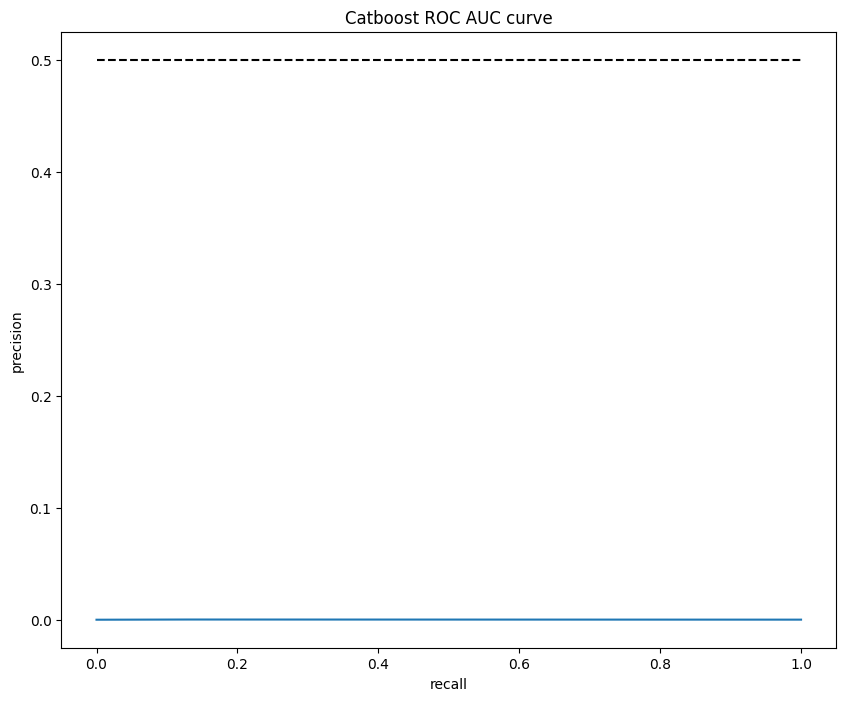

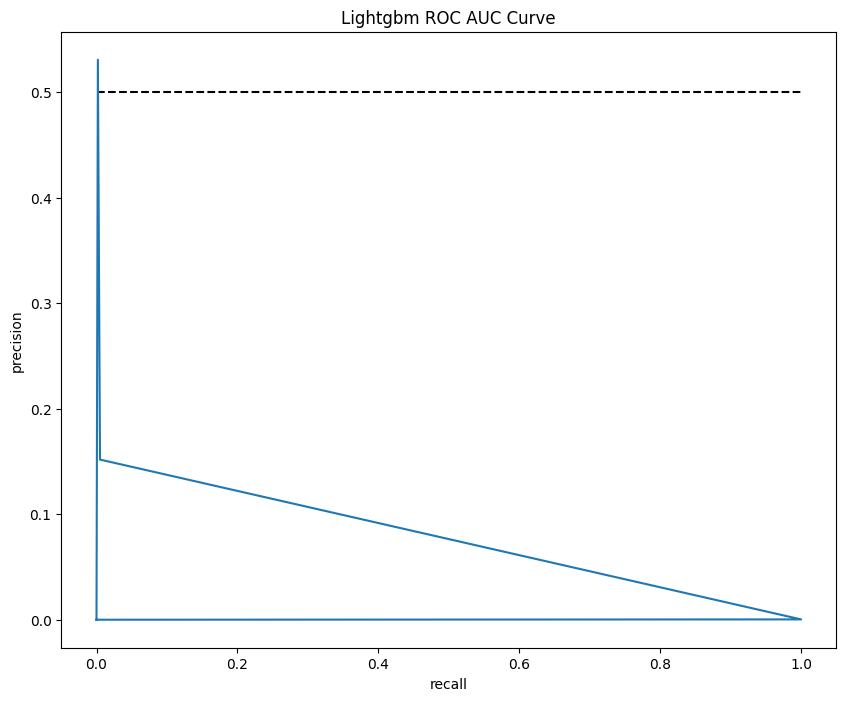

In [ ]:
# **Calculating metrics for CatBoost classifier**
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

accuracy_catboost = accuracy_score(y_test_C, y_pred_catboost_labels)
precision_catboost = precision_score(y_test_C, y_pred_catboost_labels, average = None)
recall_catboost = recall_score(y_test_C, y_pred_catboost_labels, average =None)
f1_catboost = f1_score(y_test_C, y_pred_catboost_labels, average =None)
confusion_matrix_catboost = confusion_matrix(y_test_C, y_pred_catboost_labels)

# **Calculating metrics for LightGBM classifier**

accuracy_lgbm = accuracy_score(y_test_C, y_pred_lgbm_labels)
precision_lgbm = precision_score(y_test_C, y_pred_lgbm_labels, average =None)
recall_lgbm = recall_score(y_test_C, y_pred_lgbm_labels, average =None)
f1_lgbm = f1_score(y_test_C, y_pred_lgbm_labels, average =None)
confusion_matrix_lgbm = confusion_matrix(y_test_C, y_pred_lgbm_labels)

# Print the metrics for both classifiers
print("CatBoost Classifier Metrics:")
print("Accuracy:", accuracy_catboost)
print("Precision:", precision_catboost)
print("Recall:", recall_catboost)
print("F1 Score:", f1_catboost)
#print("ROC AUC:", roc_auc_catboost)

print("LightGBM Classifier Metrics:")
print("Accuracy:", accuracy_lgbm)
print("Precision:", precision_lgbm)
print("Recall:", recall_lgbm)
print("F1 Score:", f1_lgbm)
#print("ROC AUC:", roc_auc_lgbm)

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall_catboost, precision_catboost, label = 'ROC')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Catboost ROC AUC curve')
plt.show()

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall_lgbm, precision_lgbm, label = 'ROC')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Lightgbm ROC AUC Curve')
plt.show()

Class=2, n=244885 (64.317%)
Class=3, n=133782 (35.137%)
Class=1, n=172 (0.045%)
Class=4, n=1891 (0.497%)
Class=0, n=16 (0.004%)


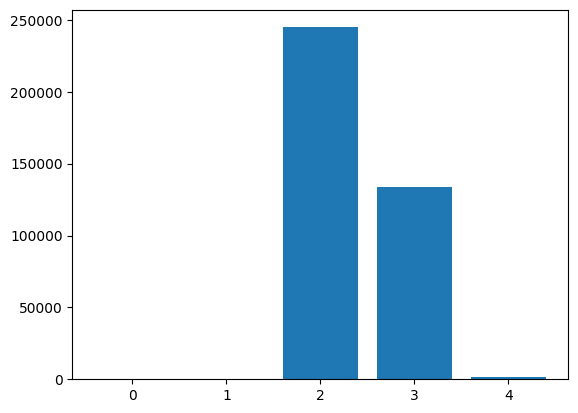

In [ ]:

from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=2, n=244885 (20.000%)
Class=3, n=244885 (20.000%)
Class=1, n=244885 (20.000%)
Class=4, n=244885 (20.000%)
Class=0, n=244885 (20.000%)


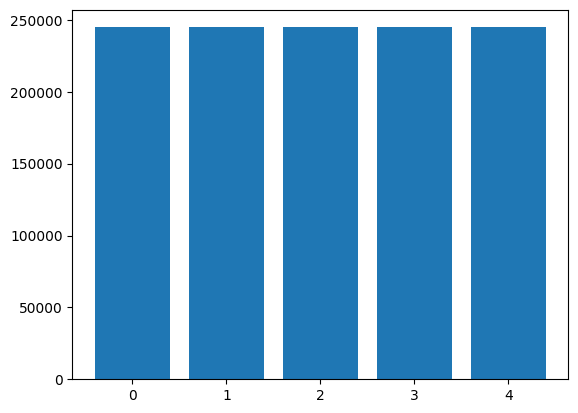

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_1, y_1 = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y_1)
for k,v in counter.items():
 per = v / len(y_1) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=16 (20.000%)
Class=1, n=16 (20.000%)
Class=2, n=16 (20.000%)
Class=3, n=16 (20.000%)
Class=4, n=16 (20.000%)


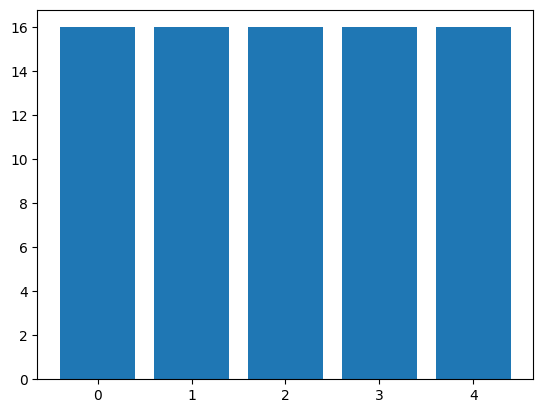

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()
X_2, y_2= undersample.fit_resample(X,y)
# summarize distribution
counter = Counter(y_2)
for k,v in counter.items():
 per = v / len(y_2) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a CatBoostRegressor object
model = CatBoostRegressor()

# Fit the RFE object to the train data
rfe = RFE(estimator=model, n_features_to_select=100)
rfe.fit(X_train, y_train)

# Select the features that were not eliminated by the RFE object
selected_features = X_train.columns[rfe.support_]

# Fit the model to the train data using the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test data
y_pred = model.predict(X_test[selected_features])



In [ ]:
class_labels = new_class_bal_data['Severity'].unique()
class_counts = {label: new_class_bal_data[new_class_bal_data['Severity'] == label].shape[0] for label in class_labels}
print(class_counts)

{2: 244885, 3: 133782, 1: 172, 4: 1891, 0: 16}


In [ ]:
# Get the majority class label
majority_class = max(class_counts, key=class_counts.get)

# Get the minority class label
minority_class = min(class_counts, key=class_counts.get)

print(f"Majority class: {majority_class}")
print(f"Minority class: {minority_class}")

Majority class: 2
Minority class: 0


In [ ]:
target_data = new_class_bal_data.copy()

Dropping rows with Severity 0 and 1 from target variable as it has less than 200 entries in entire dataset and creating data skewness

In [ ]:
target_data.drop(target_data[(target_data['Severity'] == 0) | (target_data['Severity'] == 1)].index, inplace=True)

In [ ]:
class_labels_1 = target_data['Severity'].unique()
class_counts_1 = {label: target_data[target_data['Severity'] == label].shape[0] for label in class_labels_1}
print(class_counts_1)

{2: 244477, 3: 133568, 4: 1888}


In [ ]:
out_dict= {}
for label in class_labels_1:
  out_dict[label] = target_data.shape[0]/((target_data.loc[target_data['Severity'] == label].shape[0])*len(class_labels_1))

In [ ]:
out_dict

{2: 0.5180214635050877, 3: 0.9481637318319758, 4: 67.07856638418079}

In [ ]:
# Get the majority class label
majority_class_1 = max(class_counts_1, key=class_counts_1.get)

# Get the minority class label
minority_class_1 = min(class_counts_1, key=class_counts_1.get)

print(f"Majority class: {majority_class_1}")
print(f"Minority class: {minority_class_1}")

Majority class: 2
Minority class: 4


In [ ]:
oversampled_minority_data, _ = sm.fit_resample(target_data_minority, target_data_minority[target_variable] == minority_class_new)

Class Balancing and Re-Evaluation

In [ ]:
balanced_data.info()

In [ ]:
balanced_data.head()